In [1]:
from collections import defaultdict, Counter
import elotl.corpus
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm
import os
from re import sub

In [2]:
corpusNahuatl=elotl.corpus.load('axolotl')  #español-náhuatl 
corpusOtomi=elotl.corpus.load('tsunkua')  #español-otomi 

In [3]:
def getWords(corpus):
    ### Vamos a extraer la lista de palabras para cada lengua en cada corpus: 
    corpusEs=[]
    corpusEx=[] 
    palabras=[] ### Lista temporal

    ### Iteramos sobre cada línea de los corpus y vamos guardando las palabras que corresponden a cada lengua:
    ###Corpus español-náhuatl
    for row in corpus:   
      ### row[0]: corresponde con las oraciones en español
      row[0]=sub(r'[^\w\s]',' ',row[0])     #Sustituimos signos de puntuación por un espacio
      palabras=row[0].lower().split()       #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
      for p in palabras:                    #Iteramos sobre cada palabra de la oración (lista palabras)
           corpusEs.append(p)             #vamos agregando cada palabra a una lista (corpus1_es)
      ### row[1]: corresponde con las oraciones en nahuatl   
      row[1]=sub(r'[^\w\s\']',' ',row[1])  #Sustituimo signos de puntuación por un espacio. Notemos que aparece este signo "'", también lo quitamos.
      palabras=row[1].lower().split()      #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
      for p in palabras:                      #Iteramos sobre cada palabra de la oración (lista palabras)
           corpusEx.append(p)            #vamos agregando cada palabra a una lista (corpus1_na)
    return corpusEs,corpusEx

In [4]:
palabras = getWords(corpusNahuatl)
lenguajes = ["español","nahuatl"]

In [5]:
for i in range(2):
    print("Lenguaje: {0}".format(lenguajes[i]))
    # número de palabras totales
    print("Palabras totales: {0}".format(len(palabras[i])))
    # número de palabras distintas
    print("Palabras distintas: {0}".format(len(set(palabras[i]))))

Lenguaje: español
Palabras totales: 389137
Palabras distintas: 26691
Lenguaje: nahuatl
Palabras totales: 286805
Palabras distintas: 51286


In [ ]:
def makeLogLogFit(xs,ys):
    xsfit = sm.add_constant(np.log(xs))
    # build model and train
    mod = sm.OLS(exog=xsfit,endog=np.log(ys))
    fit = mod.fit()
    # make list of predicted data
    ysfit = [np.exp(y) for y in fit.predict(xsfit)]
    # plotting results
    return fit, ysfit

In [91]:
def plotLogLogFit(xs,ysfit,textbox=False,r1=4):
    plt.plot(xs,ysfit,label="Power law fit")
    textstr = "y = {0} x^({1}) \n R^2 = {2}".format(round(np.exp(fit.params[0]),r1),round(fit.params[1],r1),round(fit.rsquared,8))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95,0.95, textstr,transform=plt.gca().transAxes,  fontsize=14,va='top',ha="right", bbox=props)

In [92]:
def plotLogLog(xs,ys,title,fit=True,norm=True):
    if norm:
        s = sum(ys)
        ys = [y/s for y in ys]
        plt.ylabel("Normalized Frecuency")
    else:
        plt.ylabel("Frecuency")
    plt.plot(xs,ys,label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.grid()
    if fit:
        fit, ysfit = makeLogLogFit(xs,ys)
        # plotting results
        plotLogLogFit(xs,ysfit)

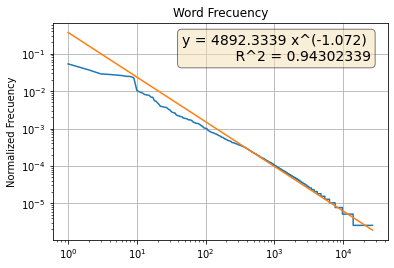

In [93]:
# plotting frecuency
counter = Counter(palabras[0])
vals = counter.most_common()
xs = range(1,len(counter.values())+1)
ys = [val[1] for val in vals]
fig = plt.figure()
plotLogLog(xs,ys,"Word Frecuency",fit=True)
plt.show()

## Building concurrency network

In [8]:
concDG = nx.DiGraph()
concDG.add_nodes_from(set(palabras[0]))
concDG.add_edges_from(zip(palabras[0][1:],palabras[0][:-1]))
nx.readwrite.graphml.write_graphml(concDG,os.path.join("networks","concurrency_esp-nah.graphml"))

In [102]:
def plotDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        degreeCounter = Counter(degreeSequence)
        degrees, count = zip(*degreeCounter.items())
        plt.figure()
        plotLogLog(degrees,count,"{1} \n {0} distribution".format(deg.replace("_"," "),title),fit=fit,norm=norm)
        plt.show()

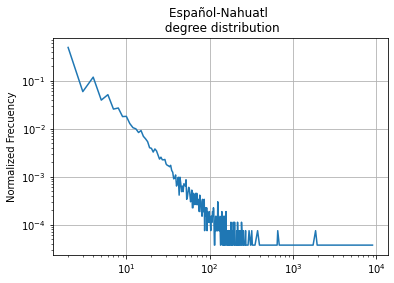

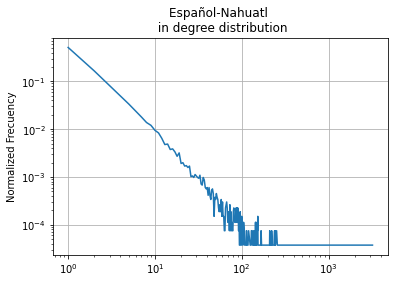

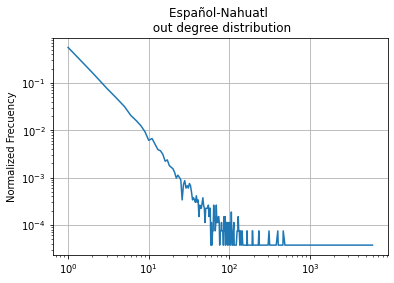

In [103]:
plotDegreeDistributions(concDG,"Español-Nahuatl",fit=False,norm=True)

In [113]:
def plotBinnedDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        m1 = degreeSequence[0]
        m2 = degreeSequence[-1]
        A = np.logspace(np.log10(m1),np.log10(m2),bins)
        plt.figure()
        if norm:
            weights = np.ones_like(degreeSequence) / float(len(degreeSequence))
            B = plt.hist(degreeSequence,bins=A,ec="k",weights=weights)
            plt.ylabel("Normalized frecuency")
        else: 
            B = plt.hist(degreeSequence,bins=A,ec="k")
            plt.ylabel("Frecuency")
        indexes = [i for i in range(len(A)-1) if B[0][i] > 0]
        xs = [(A[i]+A[i+1])/2 for i in indexes]
        ys = [B[0][i] for i in indexes]
        fit, ysfit = makeLogLogFit(xs,ys)
        plotLogLogFit(xs,ysfit)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Degree")
        
        plt.title("{1} \n {0} binned distribution".format(deg.replace("_"," "),title))
        plt.grid()

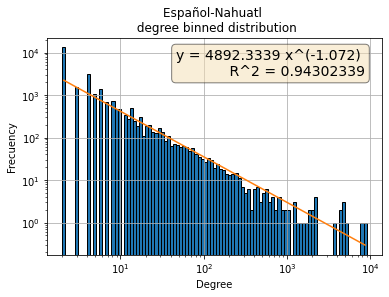

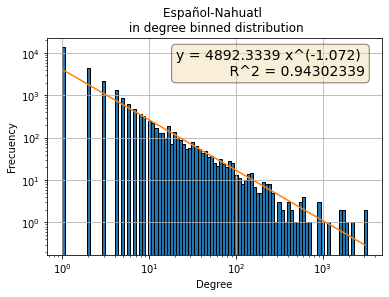

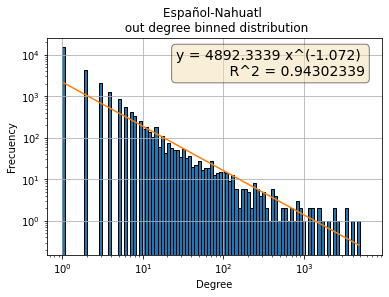

In [114]:
plotBinnedDegreeDistributions(concDG,"Español-Nahuatl",bins=100,norm=False)